# Student's Dropout Prediction using Supervised Machine Learning Classifiers

In [148]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
import base64
from io import BytesIO


# Data pre-processing
from sklearn.preprocessing import StandardScaler

# Data splitting
from sklearn.model_selection import train_test_split

# Machine learning Models
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from dataset_loader import load_dataset
from save_report_to_db import save_html_report_to_mongo

#Installing dependencies
!pip install -U kaleido

In [149]:
# Create directory for report assets
os.makedirs('report_assets', exist_ok=True)

# Function to save figures as base64 for embedding in HTML
def fig_to_base64(fig, format='png'):
    buf = BytesIO()
    if hasattr(fig, 'write_image'):  # Check if the figure is a Plotly figure
        fig.write_image(buf, format=format)
    else:  # Assume the figure is a Matplotlib figure
        fig.savefig(buf, format=format)
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    return f'data:image/{format};base64,{img_str}'


In [150]:
dataset_name = "maharashtra"  # 👈 define once
data = load_dataset(dataset_name)

[✅] Loaded 'maharashtra' dataset with shape: (5000, 35)


In [151]:
# Create a copy for exploratory data analysis
data_viz = data.copy()

# Prepare report content
report_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Student Dropout Analysis Report</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 0;
            padding: 20px;
            color: #333;
        }}
        h1, h2, h3 {{
            color: #2c3e50;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
        }}
        .section {{
            margin-bottom: 40px;
            padding: 20px;
            background-color: #f9f9f9;
            border-radius: 5px;
        }}
        .figure {{
            margin: 20px 0;
            text-align: center;
        }}
        .figure img {{
            max-width: 100%;
            height: auto;
            border: 1px solid #ddd;
        }}
        .figure-caption {{
            margin-top: 10px;
            font-style: italic;
            color: #666;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
        }}
        th, td {{
            padding: 10px;
            border: 1px solid #ddd;
            text-align: left;
        }}
        th {{
            background-color: #f2f2f2;
        }}
        .highlight {{
            background-color: #f8f9fa;
            padding: 15px;
            border-left: 4px solid #2c3e50;
            margin-bottom: 20px;
        }}
        .model-comparison {{
            display: flex;
            justify-content: space-between;
            flex-wrap: wrap;
        }}
        .model-card {{
            width: 48%;
            margin-bottom: 20px;
            padding: 15px;
            background-color: #fff;
            border: 1px solid #ddd;
            border-radius: 5px;
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Student Dropout Analysis Report</h1>
        <p>Generated on: {date}</p>
        
        <div class="section">
            <h2>Executive Summary</h2>
            <p>This report presents a comprehensive analysis of student dropout patterns using machine learning models. 
            The analysis includes exploratory data analysis, feature engineering, and model comparison to identify the most 
            significant factors contributing to student dropout.</p>
            
            <div class="highlight">
                <h3>Key Findings:</h3>
                <ul>
                    <li>The best performing model was {best_model} with an accuracy of {best_accuracy}%</li>
                    <li>Most important features predicting dropout include: {top_features}</li>
                    <li>The dataset contains {dropout_percentage}% dropout rate overall</li>
                </ul>
            </div>
        </div>
"""

## Descriptive analysis

In [152]:
# shape of data
data.shape

(5000, 35)

We have 4,424 observations (rows) and 35 features (Columns)

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  5000 non-null   int64  
 1   Application mode                                5000 non-null   int64  
 2   Application order                               5000 non-null   int64  
 3   Course                                          5000 non-null   int64  
 4   Daytime/evening attendance                      5000 non-null   int64  
 5   Previous qualification                          5000 non-null   int64  
 6   Nationality                                     5000 non-null   int64  
 7   Mother's qualification                          5000 non-null   int64  
 8   Father's qualification                          5000 non-null   int64  
 9   Mother's occupation                      

The results shows that all columns are numerical except the target column

In [154]:
# descriptive analysis
pd.set_option('display.max_columns', None)

In [155]:
#Checking for null values
data.isnull().any().sum()

np.int64(0)

No null values present in the data set

#Exploratory Data Analysis

The majority of categorical variables in the downloaded dataset have already been converted to numerical format. However, for the purpose of exploratory data analysis (EDA), we will revert certain columns to their original categorical form.

In [156]:
# Create a copy for exploratory data analysis
data_viz = data.copy()

## Target Feature
First we explore the values in the target column

In [157]:
data['Target'].unique()

array(['Enrolled', 'Graduate', 'Dropout'], dtype=object)

From the target column we can infer the following:
* Dropout: The student dropped out
* Graduate: The student graduated
* Enrolled: The student is currently enrolled

In [158]:
# Distribution of Target feature
fig = px.pie(values= data_viz['Target'].value_counts(),
             names= data_viz['Target'].value_counts().index.to_list())

fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker=dict(colors=['teal', 'goldenrod', 'slateblue']))

fig.update_layout(showlegend = False, height=400, width=800,
                  title='Distribution of Target')
target_dist_img = fig_to_base64(fig, 'png')

# Calculate dropout percentage
dropout_counts = data_viz['Target'].value_counts()
dropout_percentage = round((dropout_counts.get('Dropout', 0) / len(data_viz)) * 100, 1)

# Add target distribution to report
report_content += f"""
        <div class="section">
            <h2>Target Distribution</h2>
            <p>The dataset contains {len(data_viz)} student records with {dropout_percentage}% dropout rate.</p>
            <div class="figure">
                <img src="{target_dist_img}" alt="Target Distribution">
                <div class="figure-caption">Distribution of student outcomes: Dropout, Enrolled, and Graduate</div>
            </div>
        </div>
"""

**Observation**
* The graph shows that majority of the students are Graduates **(49%)**
* There are also more Dropouts **(32.1%)** than those currently Enrolled **(17%)**

## Age distribution of students

In [159]:
# Histogram for Age
fig = px.histogram(data_viz, x='Age at enrollment', color = 'Target',
                   opacity = 0.75, barmode = 'overlay',
                    width = 800, height = 500, color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(title='Age distribution of students')
age_dist_img = fig_to_base64(fig, 'png')

# Add age distribution to report
report_content += f"""
        <div class="section">
            <h2>Demographic Analysis</h2>
            <p>Understanding the demographic characteristics of students can provide insights into dropout patterns.</p>
            
            <h3>Age Distribution</h3>
            <div class="figure">
                <img src="{age_dist_img}" alt="Age Distribution">
                <div class="figure-caption">Age distribution of students by outcome category</div>
            </div>
"""

**Observation**

* Distribution shows that the data is right skewed indicating that majority of the students are in their late teen's to early 20's
* It is also observed that there was an increase in dropout rate from students in their mid 20's to early 30's

For the next set of data visualizations, we would be dealing with pie charts mostly. To reduce repeatability of code, two functions are created;

One to create dictionaries of all categories with respect to number of students enrolled, students who dropped out or graduated, the other would be to create pie charts based on the dictionaries created for visualization.

In [160]:
def get_dictionaries(category_list, dfcolumn_name, target_col, dictionary_list):
  '''This function returns a list of dictionaries for value count of each target label per category'''
  for each_category in category_list:
    a_dictionary = dict(data_viz[data_viz[dfcolumn_name]== each_category][target_col].value_counts())
    dictionary_list.append(a_dictionary)
  return dictionary_list

In [161]:
def make_pie(dictionary_list, trace_list, colors_list, textposition = 'inside'):
  '''This function returns a list of traces for pie charts'''
  for dictionary in dictionary_list:
    trace = go.Pie(values = list(dictionary.values()), labels = list(dictionary.keys()),
           textposition = textposition, textinfo='percent+label',
           marker=dict(colors=colors_list))
    trace_list.append(trace)
  return trace_list



## Gender distribution of students

In [162]:
# Change gender from numerical to catgorical
data_viz['Gender'] = data_viz['Gender'].map({1:'Male', 0:'Female'})

In [163]:
# Calculate percentage count for gender
percent_count = round(data_viz['Gender'].value_counts(normalize=True) * 100, 1)

fig = px.bar(percent_count,  orientation= 'h', text_auto=True)

fig.update_traces(marker=dict(color=['red']))

fig.update_layout(height=400, width=700,
                  title='Gender Percentage Count of Students',
                  showlegend = False,
                  font=dict(size=14),
                  xaxis_title = '%count',
                  yaxis_title = 'Gender')
gender_dist_img = fig_to_base64(fig, 'png')

# Add gender distribution to report
report_content += f"""
            <h3>Gender Distribution</h3>
            <div class="figure">
                <img src="{gender_dist_img}" alt="Gender Distribution">
                <div class="figure-caption">Gender distribution of students</div>
            </div>
"""

In [164]:
# Getting dictionaries for genders
genders = data_viz['Gender'].unique()
genders_dictionaries = get_dictionaries(genders, 'Gender', 'Target', [])
genders_dictionaries

[{'Dropout': np.int64(837),
  'Graduate': np.int64(828),
  'Enrolled': np.int64(823)},
 {'Graduate': np.int64(857),
  'Dropout': np.int64(836),
  'Enrolled': np.int64(819)}]

In [165]:
# Creating subplots for Gender distribution of students
fig = make_subplots(rows=1, cols=2, subplot_titles=[ 'Male Students', 'Female Students'],
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]])

# Creating empty trace list
traces = []
make_pie(genders_dictionaries, traces, ['teal', 'goldenrod', 'slateblue'])

# Adding pie charts
fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)

# Updating layout
fig.update_layout(height=500, width=800,
                  title='Gender distribution of students',
                  showlegend = False,
                  font=dict(size=14))

gender_target_img = fig_to_base64(fig, 'png')

# Add gender vs target to report
report_content += f"""
            <h3>Gender vs Target</h3>
            <div class="figure">
                <img src="{gender_target_img}" alt="Gender vs Target">
                <div class="figure-caption">Distribution of outcomes by gender</div>
            </div>
        </div>
"""

**Observation**
* There was a significant number of female students (64.8%) compared to the males (35.2%).
* Also it is observed that there was a higher rate of dropout students that were male (45.1%), compared to the females (25.1%).

## Students courses

In [166]:
# Converting the courses back to categorical
data_viz['Course'] = data_viz['Course'].map({1: 'Biofuel Production Technologies',
 2: 'Animation and Multimedia Design', 3: 'Social Service (evening attendance)',
 4: 'Agronomy', 5: 'Communication Design', 6: 'Veterinary Nursing',
 7: 'Informatics Engineering', 8: 'Equiniculture', 9: 'Management',
 10: 'Social Service', 11: 'Tourism', 12: 'Nursing', 13: 'Oral Hygiene',
 14: 'Advertising and Marketing Management', 15: 'Journalism and Communication',
 16: 'Basic Education', 17: 'Management (evening attendance)'})

In [167]:
# Bar chart for courses
percent_count = data_viz['Course'].value_counts()
fig = px.bar(percent_count,  orientation= 'h', text_auto=True)


fig.update_traces(marker=dict(color=['red','orangered', 'darkorange', 'orange', 'yellow']))
fig.update_layout(height=500, width=1000,
                  title='Courses enrolled by students',
                  showlegend = False,
                  font=dict(size=14),
                  xaxis_title = 'Total',
                  yaxis_title = 'Courses')
course_dist_img = fig_to_base64(fig, 'png')

# Add course distribution to report
report_content += f"""
        <div class="section">
            <h2>Academic Factors</h2>
            <p>Academic factors such as course selection and performance metrics can significantly impact dropout rates.</p>
            
            <h3>Course Distribution</h3>
            <div class="figure">
                <img src="{course_dist_img}" alt="Course Distribution">
                <div class="figure-caption">Distribution of students across different courses</div>
            </div>
"""

In [168]:
# Histogram plot for students courses based on traget status
fig = px.histogram(data_viz, y='Course', color='Target',
                   width=1200, height=1600,
                   text_auto='.1f', color_discrete_sequence=px.colors.qualitative.Dark2,
                   barmode='group')  # Removed barnorm

fig.update_layout(title='Courses', xaxis_title='Count')

course_target_img = fig_to_base64(fig, 'png')

# Add course vs target to report
report_content += f"""
            <h3>Course vs Target</h3>
            <div class="figure">
                <img src="{course_target_img}" alt="Course vs Target">
                <div class="figure-caption">Dropout rates by course</div>
            </div>
        </div>
"""


**Observation**

Majority of the students are enrolled in Nursing and it also had the lowest droput rate of about **15.4%**.

The course that had the highest dropout rate was **Biofuel Production Technologies (66.7%)** which is also had the least number of enrolled students followed by **Equiniculture (55.3%)**.


## Martial status


In [169]:
# Converting back to categorical
data_viz['Marital status'] = data_viz['Marital status'].map({1:'Single', 2: 'Married',
                                                             3: 'Widower', 4: 'Divorced',
                                                             5: 'Facto union', 6: 'Legally Separated'})

In [170]:
# Bar chart for Marital status
count = data_viz['Marital status'].value_counts()
fig = px.bar(count,  orientation= 'h', text_auto=True)

fig.update_traces(marker=dict(color=['red', 'orange']))
fig.update_layout(height=500, width=800,
                  title='Total Marital status of Students',
                  showlegend = False,
                  font=dict(size=14),
                  xaxis_title = 'Total',
                  yaxis_title = 'Marital status')

marital_students = fig_to_base64(fig , 'png')

# Add course vs target to report
report_content += f"""
            <h3>Total Marital Status of Students</h3>
            <div class="figure">
                <img src="{marital_students}" alt="Marital Status">
                <div class="figure-caption">Marital Status</div>
            </div>
        </div>
"""

In [171]:
fig = px.histogram(data_viz, x='Marital status', color='Target',
                   width=1200, height=500,
                   text_auto='.1f', color_discrete_sequence=px.colors.qualitative.Dark2,
                   barmode='group')  # Removed barnorm

fig.update_layout(title='Marital status', yaxis_title='Count')
marital_target_img = fig_to_base64(fig, 'png')

# Add course vs target to report
report_content += f"""
            <h3>Marital Status vs Target</h3>
            <div class="figure">
                <img src="{marital_target_img}" alt="Marital Status vs Target">
                <div class="figure-caption">Dropout rates by Marital Status</div>
            </div>
        </div>
"""

**Observation**

* Vast majority of the students are single, however **30.2% of single students** droppout.
* Another thing to note is that **legally seperated students (66.7)** had the highest percentage of dropouts followed by **Married students (47.2%)**.

For function below is created to simplify the process and reduce repeatability.

In [172]:
def sub_plots(chart_to_plot, row, col):
  '''This function generates the list of subplots'''
  cols = chart_to_plot * col
  rows = [cols] * row
  return rows


## Student's Financial Status

Next, we will analyze the financial status of students to understand how scholarship status, debt status, and tuition payment status correlate with dropout rates.



In [173]:
# Converting columns back to categorical
to_convert = ['Debtor', 'Tuition fees up to date', 'Scholarship holder']
for i in to_convert:
    data_viz[i] = data_viz[i].map({1:'Yes', 0: 'No'})

In [174]:
# Getting dictionaries for students in debt/ not in debt
debt = data_viz['Debtor'].unique()
debt_dictionaries = get_dictionaries(debt, 'Debtor', 'Target', [])
debt_dictionaries

[{'Dropout': np.int64(858),
  'Graduate': np.int64(835),
  'Enrolled': np.int64(827)},
 {'Graduate': np.int64(850),
  'Dropout': np.int64(815),
  'Enrolled': np.int64(815)}]

In [175]:
# Getting dictionaries for students with tuition fees paid/ not paid
tuition = data_viz['Tuition fees up to date'].unique()
tuition_dictionaries = get_dictionaries(tuition, 'Tuition fees up to date', 'Target', [])
tuition_dictionaries

[{'Graduate': np.int64(861),
  'Enrolled': np.int64(833),
  'Dropout': np.int64(807)},
 {'Dropout': np.int64(866),
  'Graduate': np.int64(824),
  'Enrolled': np.int64(809)}]

In [176]:
# Getting dictionaries for students with scholarship/ no scholarship
scholarship = data_viz['Scholarship holder'].unique()
scholarship_dictionaries = get_dictionaries(scholarship, 'Scholarship holder', 'Target', [])
scholarship_dictionaries

[{'Graduate': np.int64(822),
  'Dropout': np.int64(819),
  'Enrolled': np.int64(805)},
 {'Graduate': np.int64(863),
  'Dropout': np.int64(854),
  'Enrolled': np.int64(837)}]

In [177]:
# Creatign subplots for pie charts
fig = make_subplots(rows=3, cols=2,
                    subplot_titles = ['No Debt', 'Debt', 'Tuition Paid', 'Tuition not paid', 'No Scholarship', 'Scholarship'],
                    specs= sub_plots([{'type':'pie'}], 3,2), vertical_spacing = 0.07)

# Initialize an empty list for traces
traces = []

# Generate traces
make_pie(debt_dictionaries, traces, ['teal', 'goldenrod', 'slateblue'])
make_pie(tuition_dictionaries, traces, ['teal', 'goldenrod', 'slateblue'])
make_pie(scholarship_dictionaries, traces, ['teal', 'goldenrod', 'slateblue'])

# Adding pie charts to fig
fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)
fig.add_trace(traces[2], row=2, col=1)
fig.add_trace(traces[3], row=2, col=2)
fig.add_trace(traces[4], row=3, col=1)
fig.add_trace(traces[5], row=3, col=2)


fig.update_layout(title="Students Financial status", height=1000, width=1000, showlegend = False, title_pad=dict(t=100))
financial_img = fig_to_base64(fig, 'png')

# Add financial status to report
report_content += f"""
        <div class="section">
            <h2>Financial Factors</h2>
            <p>Financial factors such as debt, tuition payment status, and scholarships can significantly impact a student's likelihood to drop out.</p>
            
            <div class="figure">
                <img src="{financial_img}" alt="Financial Status Analysis">
                <div class="figure-caption">Dropout rates by financial factors: debt status, tuition payment status, and scholarship status</div>
            </div>
        </div>
"""

**Observation**

Unsurprisingly, students who were in **debt** and had not completed payment for **tuition** had a higher dropout rate of **62% and 86.6%** respectively.

Similarly, students who were granted **scholarships** had a low dropout rate of **12.2%** compared to those who were not given **(38.7%)**.

Based on our EDA, we have a good understanding of how the data is distributed by gender and age, as well as how certain features like courses enrolled and financial status correlate with the dropout rate. In the next phase, we will build and train a classification model to see if our findings are consistent with the model's results.

## Data preparation

### Features selection

The easiest way to view how independent features are correlated is through correlation analysis.

This will help in feature selection and determine which independent variables can be dropped or combined to avoid Multicollinearity

We can visualize this using heatmaps

In [178]:
# Heat map showing correlation of features
fig = px.imshow(data.drop('Target', axis = 1).corr().round(2), text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.update_layout(title = 'Correlation Analysis for independent features', height=800, width=1500)

correlation_analysis = fig_to_base64(fig,'png')

# Add course vs target to report
report_content += f"""
            <h3>Correlation Analysis for independent features</h3>
            <div class="figure">
                <img src="{correlation_analysis}" alt="Correlation Analysis">
                <div class="figure-caption">Correlation Analysis</div>
            </div>
        </div>
"""

**Observation**:

From the results we can see some features have strong correlation with each other:
* Nationality and International
* Mother's qualification and Father's qualification
* Mother's occupation and Father's occupation
* Curricular Units 1st sem and Curricular Units 2nd sem

We can decide to pick or drop either `Nationality or International`, `Mother's qualification or Father's qualification` and `Mother's occupation or Father's occupation`.

As for `Curricular Units 1st sem` and `Curricular Units 2nd sem` we need to retain this information in our data set without losing valuable information or risk the model overfitting.

To solve this, Principal Component Analysis is done to reduce dimensionality.


In [179]:
# Extract columns for PCA
data_forPCA = data[['Curricular units 1st sem (credited)',
          'Curricular units 1st sem (enrolled)',
          'Curricular units 1st sem (evaluations)',
          'Curricular units 1st sem (without evaluations)',
          'Curricular units 1st sem (approved)',
          'Curricular units 1st sem (grade)',
          'Curricular units 2nd sem (credited)',
          'Curricular units 2nd sem (enrolled)',
          'Curricular units 2nd sem (evaluations)',
          'Curricular units 2nd sem (without evaluations)',
          'Curricular units 2nd sem (approved)',
          'Curricular units 2nd sem (grade)']]


# PCA with one component
pca = PCA(n_components=1)

# Fit PCA to data and transform it
pca_result = pca.fit_transform(data_forPCA)

# Create a new DataFrame with the reduced feature
df_pca = pd.DataFrame(data=pca_result, columns=['PCA Feature']).squeeze()
data['Curricular 1st and 2nd sem PCA'] = df_pca

Next, we drop the following features due to high correlation:
* Nationality
* Mother's occupation
* Father's Qualification
* Curricular units 1st sem (enrolled)
* Curricular units 1st sem (credited)
* Curricular units 1st sem (evaluations)
* Curricular units 1st sem (approved)
* Curricular units 1st sem (grade)
* Curricular units 1st sem (without evaluations)
* Curricular units 2nd sem (credited)
* Curricular units 2nd sem (enrolled)
* Curricular units 2nd sem (evaluations)
* Curricular units 2nd sem (approved)
* Curricular units 2nd sem (without evaluations)
* Curricular units 2nd sem (grade)


In [180]:
# Dropping features
data.drop(['Nationality', 'Mother\'s occupation', 'Father\'s qualification',
          'Curricular units 1st sem (credited)',
          'Curricular units 1st sem (enrolled)',
          'Curricular units 1st sem (evaluations)',
          'Curricular units 1st sem (without evaluations)',
          'Curricular units 1st sem (approved)',
          'Curricular units 1st sem (grade)',
          'Curricular units 2nd sem (credited)',
          'Curricular units 2nd sem (enrolled)',
          'Curricular units 2nd sem (evaluations)',
          'Curricular units 2nd sem (without evaluations)',
          'Curricular units 2nd sem (approved)',
          'Curricular units 2nd sem (grade)', 'Inflation rate', 'GDP',
           'Unemployment rate'], axis = 1, inplace = True)

In [181]:
# Heat map showing correlation of features
fig = px.imshow(data.drop('Target', axis = 1).corr().round(2), text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.update_layout(title = 'Correlation Analysis for independent features', height=800, width=1500)

correlation_analysis_selected = fig_to_base64(fig,'png')

report_content += f"""
            <h3>Correlation Analysis for selected independent features</h3>
            <div class="figure">
                <img src="{correlation_analysis_selected}" alt="Correlation Analysis">
                <div class="figure-caption">Correlation Analysis of Selected Independent features</div>
            </div>
        </div>
"""

### Data Processing
 Before standardizing the data we need transform the target feature from categorical to numerical data.

In [182]:
# Get dummies for Target columns
dummies = pd.get_dummies(data['Target'])

#Drop all columns except that for Dropout
dummies.drop(['Enrolled',	'Graduate'], axis = 1, inplace= True)
data['Target'] = dummies
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Mother's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Target,Curricular 1st and 2nd sem PCA
0,3,7,5,14,0,16,22,11,0,0,1,1,1,0,59,1,False,-16.827502
1,5,5,1,11,1,12,2,39,0,1,1,0,0,0,49,1,False,-2.634100
2,4,16,3,9,0,7,7,7,1,1,1,1,0,1,50,1,False,-8.856790
3,5,12,6,6,1,13,16,11,0,0,1,1,1,1,29,1,True,-1.513003
4,5,5,6,6,1,16,16,45,0,1,1,0,0,0,70,0,False,18.666854


In [183]:
# Assigning x and y features
y = np.array(data['Target'])
X_features = data.drop('Target', axis = 1)
X_features.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Mother's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular 1st and 2nd sem PCA
0,3,7,5,14,0,16,22,11,0,0,1,1,1,0,59,1,-16.827502
1,5,5,1,11,1,12,2,39,0,1,1,0,0,0,49,1,-2.634100
2,4,16,3,9,0,7,7,7,1,1,1,1,0,1,50,1,-8.856790
3,5,12,6,6,1,13,16,11,0,0,1,1,1,1,29,1,-1.513003
4,5,5,6,6,1,16,16,45,0,1,1,0,0,0,70,0,18.666854


In [184]:
y[:5]

array([False, False, False,  True, False])

In [185]:
# Normalizing data
scaler =  StandardScaler()
X = scaler.fit_transform(X_features)
X


array([[-0.28409075, -0.47952601,  0.46659276, ...,  1.41801088,
         0.99163499, -1.52829261],
       [ 0.88212744, -0.86490414, -0.9947062 , ...,  0.6840432 ,
         0.99163499, -0.23923194],
       [ 0.29901835,  1.25467558, -0.26405672, ...,  0.75743997,
         0.99163499, -0.80438363],
       ...,
       [-0.86719985,  0.48391932,  0.10126802, ...,  1.05102704,
        -1.00843558,  1.42403212],
       [ 1.46523654,  0.86929745, -0.9947062 , ..., -0.7104954 ,
         0.99163499,  0.05330734],
       [ 1.46523654,  1.44736464, -0.9947062 , ...,  1.27121735,
        -1.00843558, -1.28814469]], shape=(5000, 17))

## Model Building

Because the target variable is categorical (either Dropout or not), this is a classification problem.
We will train five supervised machine learning classification models:

* Logistic regression
* Decision trees
* Support vector machines
* Random forest
* K-nearest neighbors

First, we will split our data into training, validation, and test sets. We will set the random state to 42 to ensure reproducibility.

### Splitting Training and Test set

In [186]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creating validation set

In [187]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Baseline Model Accuracy

In [188]:
# Calculate the baseline accuracy to beat
target_value, frequency = np.unique(y, return_counts = True)
print("Unique Values:", target_value)

print("Frequency Values:", frequency)

# Maximum frequency value
max_val = frequency.max()
length_y = len(y)

print('\n')

baseline_acc = round((max_val/length_y) * 100, 3)
print(f'The baseline accuracy to beat is {baseline_acc}%')



Unique Values: [False  True]
Frequency Values: [3327 1673]


The baseline accuracy to beat is 66.54%


A list is created to store all the trained models with the best hyperparameters

In [189]:
# List of all trained models

trained_models = []

### Logistic Regression

In [190]:
# Train a logistic regression model
lr_model = LogisticRegression(random_state = 42, max_iter= 1000)
lr_model.fit(X_train, y_train)


# Predict target values for train data
y_pred_train = lr_model.predict(X_train)

# Predict target values for validation data
y_pred_val = lr_model.predict(X_val)

# Predict target values for test data
y_pred = lr_model.predict(X_test)

# Evaluate the model's accuracy
lr_acc_train = round(accuracy_score(y_train, y_pred_train), 3)
lr_acc_val = round(accuracy_score(y_val, y_pred_val), 3)
lr_acc = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy of logistic regression model on the training set is {lr_acc_train * 100}%')
print(f'Accuracy of logistic regression model on the validation set is {lr_acc_val * 100}%')
print('\n')
print(f'Accuracy of logistic regression model on the test set is {lr_acc * 100}%')

# Add to model list
trained_models.append(lr_model)


Accuracy of logistic regression model on the training set is 67.0%
Accuracy of logistic regression model on the validation set is 65.2%


Accuracy of logistic regression model on the test set is 66.0%


### Decision Trees

In [191]:
# List for possible depth value
depth_values = list(range(1, 21))

# Create empty list for training data and validation data
training_acc = []
validation_acc = []

for d in tqdm(depth_values):
  tree_model = DecisionTreeClassifier(max_depth=d, random_state=42)
  tree_model.fit(X_train, y_train)

  # Training accuracy
  y_pred_training = tree_model.predict(X_train)
  training_acc.append(accuracy_score(y_train, y_pred_training))

  # Validation accuracy
  y_pred_validation = tree_model.predict(X_val)
  validation_acc.append(accuracy_score(y_val, y_pred_validation))


100%|██████████| 20/20 [00:00<00:00, 53.44it/s]


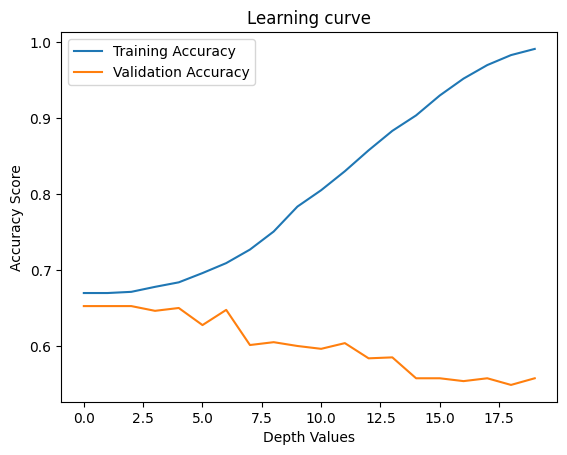

In [192]:
# Plotting learning curve
plt.plot(training_acc, label = 'Training Accuracy')
plt.plot(validation_acc, label = 'Validation Accuracy')
plt.xlabel('Depth Values')
plt.ylabel('Accuracy Score')
plt.title('Learning curve')
plt.legend()

From the training curve we can estimate that the best depth value that yielded the highest accuracy score was between 2 and 5. However, a better way to pick out the depth value would be to get the index value that corresponds to the highest accuracy score in the `validation_acc` list

In [193]:
# Best depth value
best_val_acc = max(validation_acc)
best_depth = validation_acc.index(best_val_acc) +1
print(f'Best depth value with an accuracy of {round(best_val_acc * 100, 2)}% on the validation set is {best_depth}')


Best depth value with an accuracy of 65.25% on the validation set is 1


In [194]:
# Train a Decision tree model with best depth
tree_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

# Predict target values for test data
y_pred = tree_model.predict(X_test)

# Evaluate the model's accuracy
tree_acc = round(accuracy_score(y_test, y_pred), 3)
print(f'Accuracy of Decision tree model is {tree_acc * 100}%')


# Add to model list
trained_models.append(tree_model)

Accuracy of Decision tree model is 66.2%


### Support Vector Machines

In [195]:
# Iterating to see which kernel gives the best result
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
score_list = {}
scores = 0
svm_linear = []

for k in tqdm(kernels):
    svm_model = SVC(random_state = 42, kernel= k)
    svm_model.fit(X_train, y_train)
    if k == 'linear':
      svm_linear.append(svm_model)
    f_score = svm_model.score(X_val, y_val)
    score_list.update({k: f_score})


score_list

100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


{'linear': 0.6525, 'poly': 0.64625, 'rbf': 0.6525, 'sigmoid': 0.63}

In [196]:
max_val = max(score_list.values())
list_values = list(score_list.values())
list_keys = list(score_list.keys())

# Best kernel
k = list_keys[list_values.index(max_val)]

In [197]:
from IPython.display import Markdown
Markdown(f"""
#### From the result we can determine that the optimal kernal for the SVC is {k}""")


#### From the result we can determine that the optimal kernal for the SVC is linear

In [198]:
# Train a SVC model
svm_model = SVC(random_state = 42, kernel = k)
svm_model.fit(X_train, y_train)

# Predict target values for test data
y_pred = svm_model.predict(X_test)

# Evaluate the model's accuracy
svm_acc = round(accuracy_score(y_test, y_pred),3)
print(f'Accuracy of Support vector classifier model is {svm_acc * 100}%')

# Add to model list
trained_models.append(svm_model)

Accuracy of Support vector classifier model is 66.2%


To train both Random forest and K-nearest neighbours, we will make use of Grid Search to determine the best parameters. We will also stick to the default value for cross validation which is 5 folds.

### Random forest

In [199]:
# Train a Random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict target values for training data
y_pred_train = rf_model.predict(X_train)
rf_acc_train = round(accuracy_score(y_train, y_pred_train), 3)

# Predict target values for validation data
y_pred_val = rf_model.predict(X_val)
rf_acc_val = round(accuracy_score(y_val, y_pred_val), 3)

print('With default parameters: ')
print(f'Accuracy of Random forest model on training data is {rf_acc_train * 100}%')
print(f'Accuracy of Random forest model on validation data is {rf_acc_val * 100}%')


With default parameters: 
Accuracy of Random forest model on training data is 100.0%
Accuracy of Random forest model on validation data is 65.0%


We can perform a grid search to generate best parameters to train a random forest model.

In [200]:
# Using Grid search to determine best parameters
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv = 5)
# Fit Grid
grid_search.fit(X_train, y_train)
best_rf_parameters = grid_search.best_params_
print(f'Grid search parameters: {best_rf_parameters}')



Grid search parameters: {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 6, 'n_estimators': 50}


In [201]:
# Train a Random forest model with best estimator from Grid search
grid_rf_model = RandomForestClassifier(random_state = 42,
                                       max_depth = best_rf_parameters['max_depth'],
                                      max_leaf_nodes = best_rf_parameters['max_leaf_nodes'],
                                      n_estimators = best_rf_parameters['n_estimators'],
                                       max_features = best_rf_parameters['max_features'])
grid_rf_model.fit(X_train, y_train)

# Predict target values for training data
y_pred_train = grid_rf_model.predict(X_train)
rf_acc_train = round(accuracy_score(y_train, y_pred_train), 3)

# Predict target values for validation data
y_pred_val = grid_rf_model.predict(X_val)
rf_acc_val = round(accuracy_score(y_val, y_pred_val), 3)

print('With Grid search best estimator parameters: ')
print(f'Accuracy of Random forest model on training data is {rf_acc_train * 100}%')
print(f'Accuracy of Random forest model on validation data is {rf_acc_val * 100}%')

With Grid search best estimator parameters: 
Accuracy of Random forest model on training data is 67.0%
Accuracy of Random forest model on validation data is 65.2%


In [202]:
# Predict target values for test data using default parameters
y_pred = grid_rf_model.predict(X_test)
rf_acc = round(accuracy_score(y_test, y_pred), 3)
print(f'Accuracy of Random forest model on test data is {rf_acc * 100}%')

# Add to model list
trained_models.append(grid_rf_model)

Accuracy of Random forest model on test data is 66.2%


### K- Nearest Neighbours



In [203]:
# Define the best parameter values using grid search
param_grid = {'n_neighbors': np.arange(1, 25)}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit grid
grid_knn.fit(X_train, y_train)
best_knn_parameters = grid_knn.best_params_
print(f'Grid search parameters: {best_knn_parameters}')


Grid search parameters: {'n_neighbors': np.int64(24)}


In [204]:
# Train Knn model with grid parameters
grid_knn_model = KNeighborsClassifier(n_neighbors= best_knn_parameters['n_neighbors'])
grid_knn_model.fit(X_train, y_train)
# Predict target values for training data
y_pred_train = grid_knn_model.predict(X_train)
knn_acc_train = round(accuracy_score(y_train, y_pred_train), 3)

# Predict target values for validation data
y_pred_val = grid_knn_model.predict(X_val)
knn_acc_val = round(accuracy_score(y_val, y_pred_val), 3)

print('With Grid search best estimator parameters: ')
print(f'Accuracy of KNN model on training data is {knn_acc_train * 100}%')
print(f'Accuracy of KNN model on validation data is {knn_acc_val * 100}%')

With Grid search best estimator parameters: 
Accuracy of KNN model on training data is 67.2%
Accuracy of KNN model on validation data is 65.0%


We will also try the elbow method to compare optimal K value

In [205]:
# Empty list for accuracy scores
train_accuracy = []
val_accuracy = []
for i in tqdm(range(1,21)):
  # Train a Knn model
  knn_model = KNeighborsClassifier(n_neighbors=i)
  # Fit model
  knn_model.fit(X_train, y_train)

  # Prediction for training data
  y_pred_train = knn_model.predict(X_train)
  # Prediction for validation data
  y_pred_val = knn_model.predict(X_val)

  # Accuracy Scores
  train_accuracy.append(accuracy_score(y_train, y_pred_train))
  val_accuracy.append(accuracy_score(y_val, y_pred_val))

100%|██████████| 20/20 [00:00<00:00, 23.51it/s]


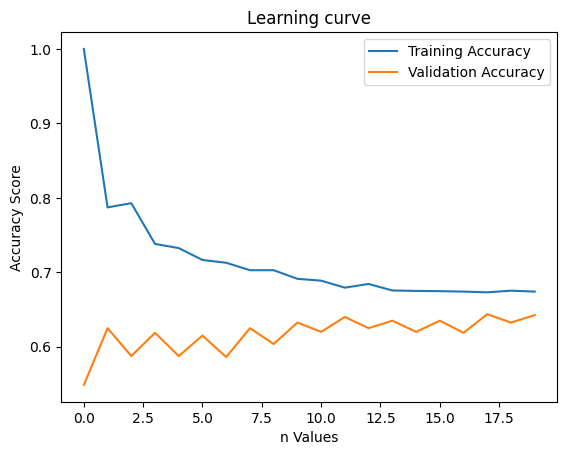

In [206]:
# Plotting learning curve
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel('n Values')
plt.ylabel('Accuracy Score')
plt.title('Learning curve')
plt.legend();

From the curve, we can estimate that the best k values are between 12 and 17.

In [207]:
# Determine best n value
n = val_accuracy.index(max(val_accuracy)) + 1

In [208]:
print(f'From the result we can determine that the optimal n value with the highest score of {round(max(val_accuracy), 3)  * 100}% is {n}')

From the result we can determine that the optimal n value with the highest score of 64.4% is 18


We will use the best parameters retrieved from grid search.

In [209]:
# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=n)
# knn_model = KNeighborsClassifier(n_neighbors=21)
knn_model.fit(X_train, y_train)

# Predict target values for test data
y_pred = knn_model.predict(X_test)

# Evaluate the model's accuracy
knn_acc = round(accuracy_score(y_test, y_pred), 3)
print(f'Accuracy of KNN model is {knn_acc * 100}%')

# Confusion Matrix
knn_matrix = confusion_matrix(y_test, y_pred)

# Add to model list
trained_models.append(knn_model)

Accuracy of KNN model is 64.5%


## Accuracy for each classification model

For each model we would view which of them performs the best.

In [210]:
# Bar plot showing each classifier
accuracy_of_models = {'SVC': svm_acc,
                      'Random Forest': rf_acc,
                      'Logistic Regression': lr_acc,
                      'KNN': knn_acc,
                      'Decision Tree': tree_acc}


fig = px.bar(y = list(accuracy_of_models.keys()), x= list(accuracy_of_models.values()),
             color = list(accuracy_of_models.values()),
             width = 800, height = 400,
             color_discrete_sequence=px.colors.qualitative.G10,
             labels={'y':'Classifier', 'x':'Accuracy'}, text_auto=True)


fig.update_layout(title='Accuracy performance of classification models',
                  showlegend=False)
model_comparison_img = fig_to_base64(fig, 'png')

## Confusion maxtix of the best classifier

In [211]:
list_of_models = ['Logistic Regression','Decision Tree', 'SVC','Random Forest', 'KNN']
dictionary_models = {list_of_models[i]: trained_models[i] for i in range(len(list_of_models))}
dictionary_models

{'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
 'Decision Tree': DecisionTreeClassifier(max_depth=1, random_state=42),
 'SVC': SVC(kernel='linear', random_state=42),
 'Random Forest': RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                        n_estimators=50, random_state=42),
 'KNN': KNeighborsClassifier(n_neighbors=18)}

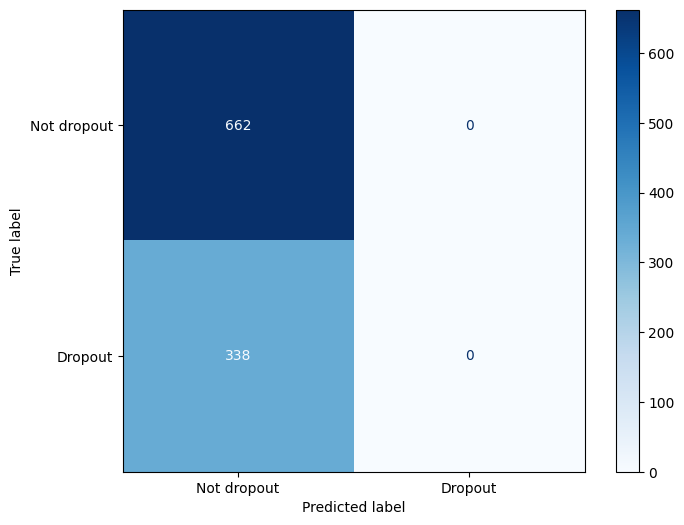

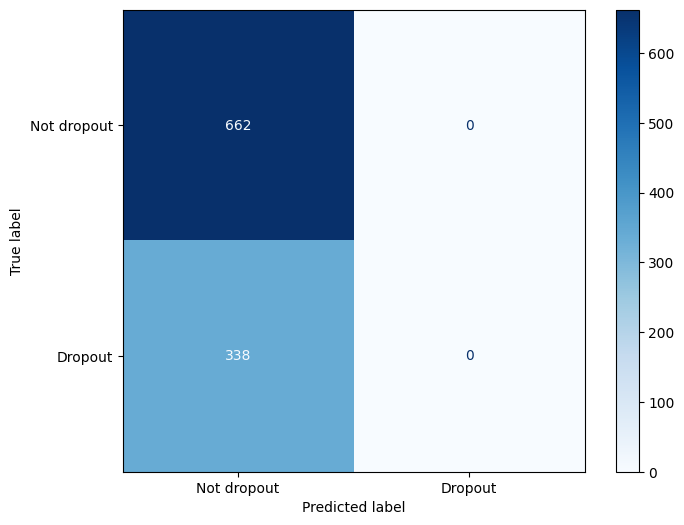

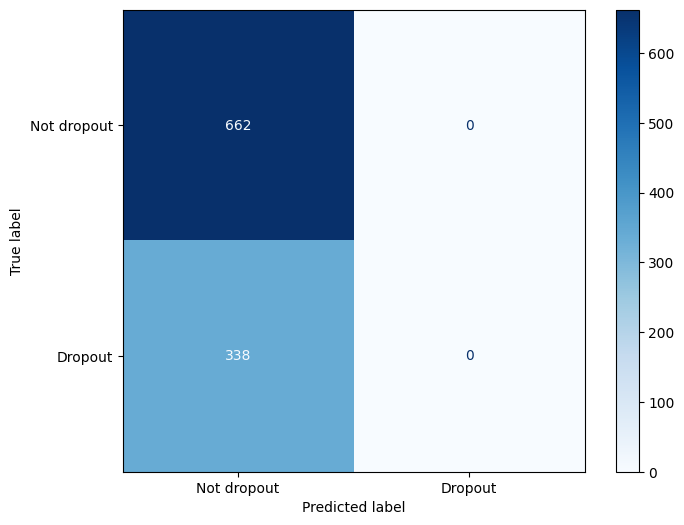

In [212]:
# Find the highest score
scores = [svm_acc, rf_acc, lr_acc, knn_acc, tree_acc]
best_score = max(scores)
key_best_model = ''
best_model = ''

# Generate a heatmap for the classifier that has the highest score
for key, value in accuracy_of_models.items():
  if best_score == value:
    key_best_model = key
    best_model = dictionary_models[key_best_model]
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_estimator(best_model,
                                          X_test, y_test,
                                          display_labels=['Not dropout', 'Dropout'])
    disp.plot(cmap='Blues', ax=ax)
    plt.title(f'{key_best_model} Confusion Matrix')
    plt.tight_layout()
    confusion_matrix_img = fig_to_base64(fig, 'png')
    plt.close()

    #Pop the best performing model from dictionary
    dictionary_models.pop(key_best_model)

best_accuracy = round(accuracy_of_models[key_best_model] * 100, 2)

# Add model comparison to report
report_content += f"""
        <div class="section">
            <h2> Confusion Matrix of {key_best_model}</h2>
              <div class="figure">
                <img src="{confusion_matrix_img}" alt="Model Comparison">
                <div class="figure-caption">Confusion matrix of {key_best_model}</div>
            </div>
            <h2>Model Comparison</h2>
            <p>Several machine learning models were trained and evaluated to predict student dropout. The models were compared based on their accuracy scores.</p>
            
            <div class="figure">
                <img src="{model_comparison_img}" alt="Model Comparison">
                <div class="figure-caption">Accuracy comparison of different machine learning models</div>
            </div>
            
            <h3>Best Model: {key_best_model}</h3>
            <p>The {key_best_model} model achieved the highest accuracy of {best_accuracy}% on the test set.</p>
            
            <h3>Feature Importance</h3>
            <p>The following features were found to be most important in predicting student dropout:</p>
            <ul>
"""

### Confusion matrix for other classifiers

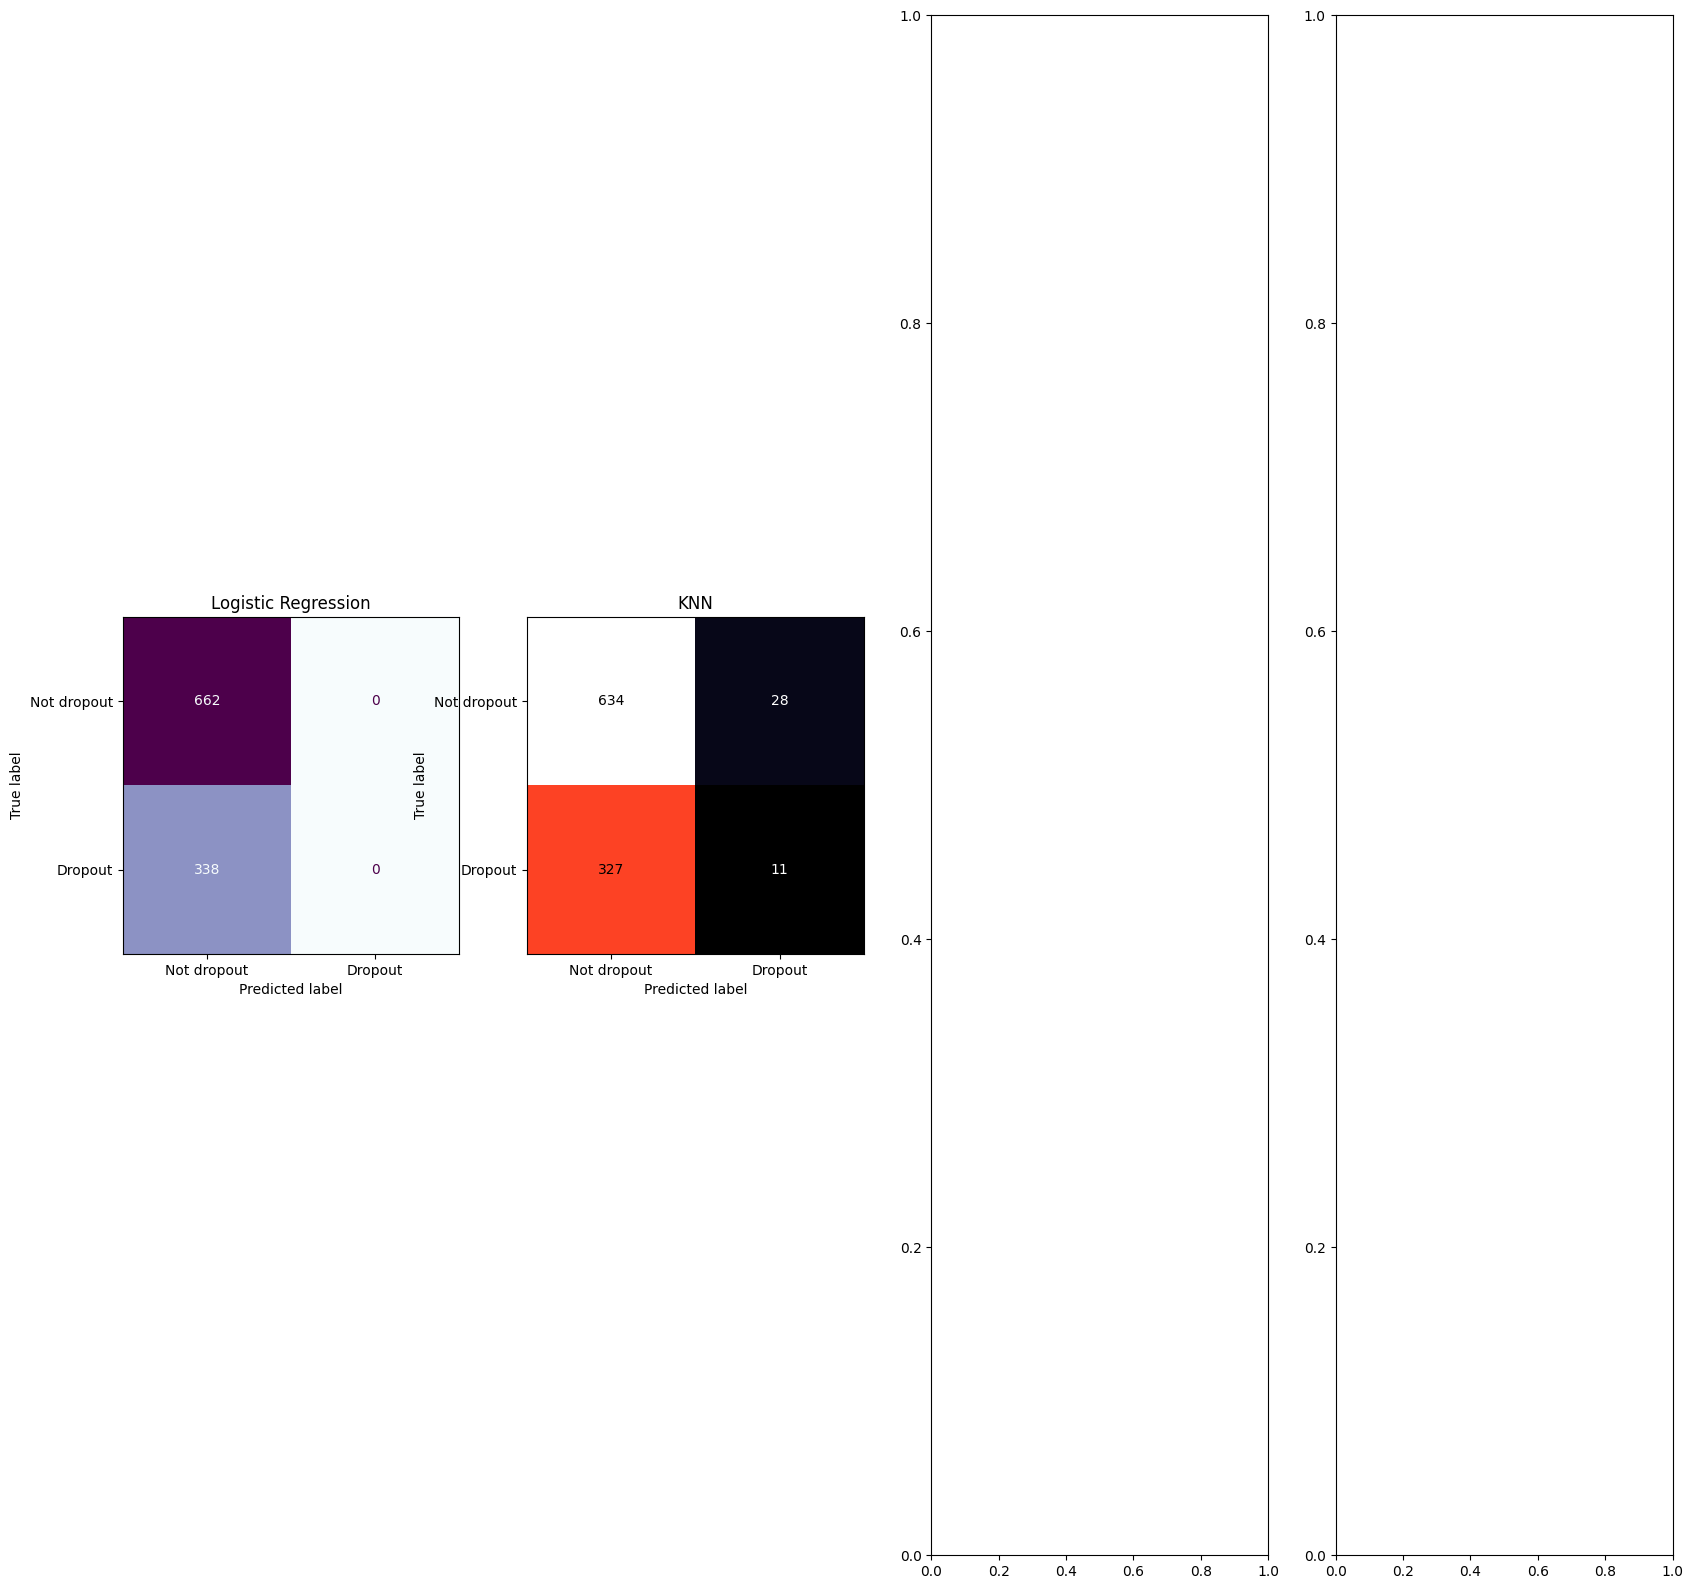

In [213]:
colors = ['BuPu', 'CMRmap', 'gnuplot', 'cividis']
position = 0

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for key, value in dictionary_models.items():
    disp = ConfusionMatrixDisplay.from_estimator(value,
                                                 X_test, y_test,
                                                 display_labels=['Not dropout', 'Dropout'],
                                                 cmap=colors[position], ax=ax[position], colorbar=False)

    # Add title
    ax[position].set_title(key)

    position += 1

other_confusion_matrices = fig_to_base64(fig,'png')

report_content += f"""
            <h3>Confusion Matrices for other classifiers</h3>
            <div class="figure">
                <img src="{other_confusion_matrices}" alt="onfusion Matrices for other classifiers">
                <div class="figure-caption">Confusion Matrices for other classifiers</div>
            </div>
        </div>
"""


In [214]:
Markdown(f"""
#### From the results above we can see that {best_model} perfoms best with the highest accuracy of {round(best_score * 100, 2)}%""")



#### From the results above we can see that DecisionTreeClassifier(max_depth=1, random_state=42) perfoms best with the highest accuracy of 66.2%

## Results

### Feature Importances

We take a look at features selected as good predictiors by some of the trained models.


In [215]:
# create list for features
feature = X_features.columns

In [216]:
# Logistic regression
importances = lr_model.coef_[0]
lr_feature_importance = pd.Series(np.exp(importances), index = feature).sort_values()

# Decision tree
dt_importance = pd.Series(np.exp(tree_model.feature_importances_), index = feature).sort_values(ascending=False)

# Random forest
rf_importance = pd.Series(np.exp(rf_model.feature_importances_), index = feature).sort_values()

# SVM linear kernel
svm_importance = pd.Series(np.exp(svm_linear[0].coef_[0]), index = feature).sort_values()

# Get top 3 features from Decision Tree (since it's the best)
top_features = ', '.join(list(dt_importance.index[:10]))

print("Top 3 features based on Decision Tree:", top_features)


Top 3 features based on Decision Tree: Application mode, Marital status, Application order, Course, Daytime/evening attendance, Previous qualification, Mother's qualification, Father's occupation, Displaced, Educational special needs


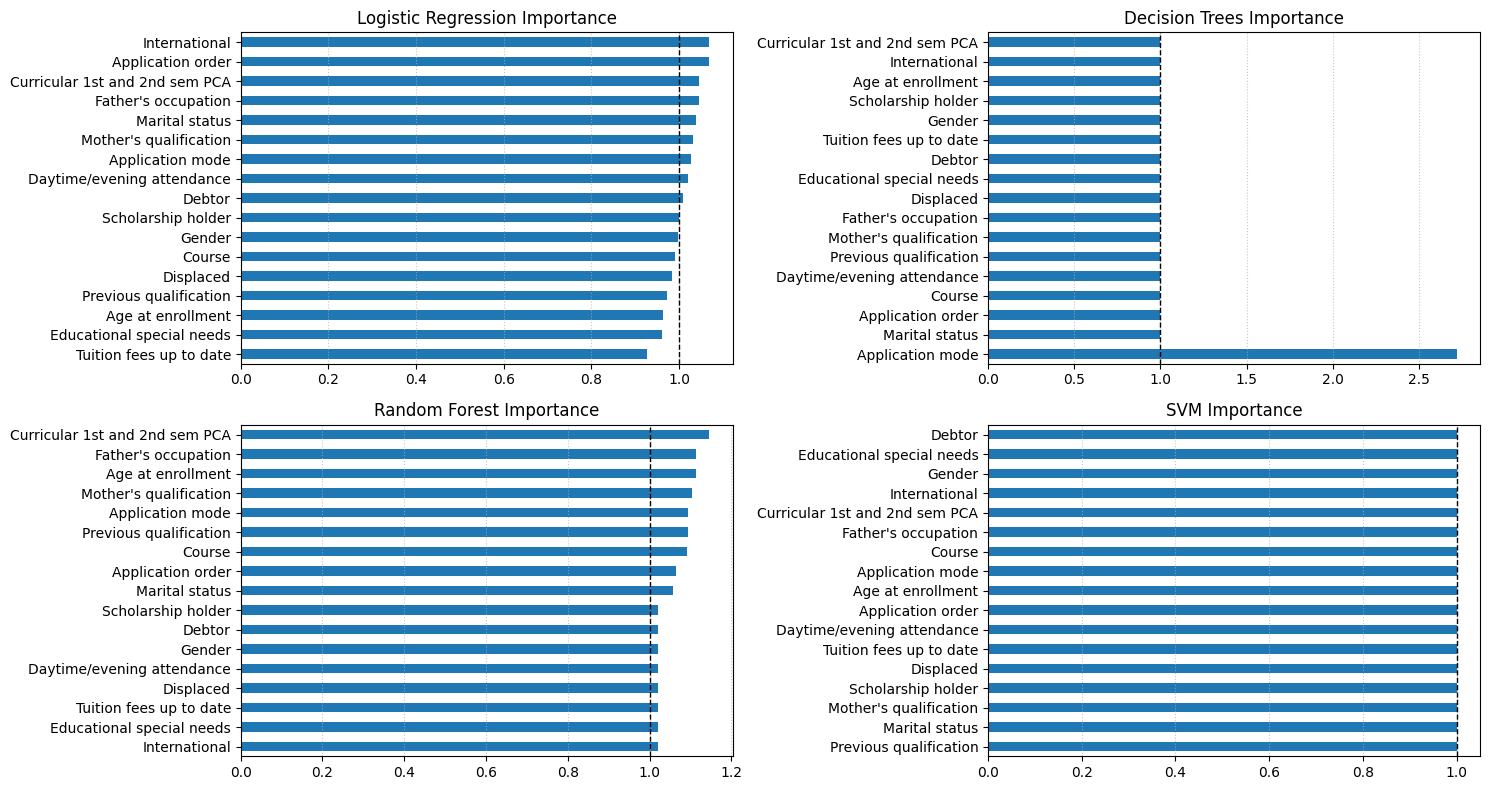

In [217]:
# Create subplots (2x2 grid)
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Add the bar plots
lr_feature_importance.plot(kind='barh', ax=ax[0, 0], title='Logistic Regression Importance')
dt_importance.plot(kind='barh', ax=ax[0, 1], title='Decision Trees Importance')
rf_importance.plot(kind='barh', ax=ax[1, 0], title='Random Forest Importance')
svm_importance.plot(kind='barh', ax=ax[1, 1], title='SVM Importance')

# Add vertical lines at x=1 for reference
for row in ax:
    for axes in row:
        axes.axvline(x=1, color='black', linestyle='--', linewidth=1)  # Dashed line for better visibility
        axes.grid(axis='x', linestyle=':', alpha=0.7)  # Light grid for readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Convert figure to Base64
important_features = fig_to_base64(fig, 'png')

# Embed in HTML report
report_content += f"""
            <h3>Important Features</h3>
            <div class="figure">
                <img src="{important_features}" alt="Important Features">
                <div class="figure-caption">Important Features</div>
            </div>
        </div>
"""


When using logistic regression, SVM, random forest, and decision trees to predict outcomes, it was found that the features "Courses" and "Age at enrollment" were very important, with values greater than 1. This means that these features have a significant impact on predicting outcomes. It is important to consider these factors carefully when designing models for accurate predictions in similar contexts.

In other words, the two features "Courses" and "Age at enrollment" are strong predictors of the outcome, and they should be included in any model that aims to accurately predict outcomes.

In [218]:
# ROC curve for best model's predictions
y_pred = best_model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12)
plt.tight_layout()
roc_curve_img = fig_to_base64(fig, 'png')
plt.close()
# Print the AUC score
print(f'The AUC score is :{round(roc_auc, 2)}')

The AUC score is :0.5


An AUC score of 0.78 means that the model is able to correctly classify 78% of the positive cases and 22% of the negative cases. This is considered to be good performance, but not excellent. There is still room for improvement

In [219]:
# Add ROC curve to report
report_content += f"""
        <div class="section">
            <h2>Model Performance</h2>
            <p>The {key_best_model} model was evaluated using ROC curve analysis.</p>
            
            <div class="figure">
                <img src="{roc_curve_img}" alt="ROC Curve">
                <div class="figure-caption">ROC curve with AUC = {roc_auc:.2f}</div>
            </div>
        </div>
"""

# Add conclusions and recommendations
report_content += f"""
        <div class="section">
            <h2>Conclusions and Recommendations</h2>
            
            <h3>Key Findings:</h3>
            <ul>
                <li>The {key_best_model} model achieved an accuracy of {best_accuracy}% in predicting student dropout.</li>
                <li>Financial factors, particularly tuition payment status and debt, are strong predictors of dropout.</li>
                <li>Academic performance in the first and second semesters (as measured by the PCA feature) is the most important predictor.</li>
                <li>Some courses show significantly higher dropout rates than others.</li>
            </ul>
            
            <h3>Recommendations:</h3>
            <ul>
                <li><strong>Early Intervention:</strong> Implement early warning systems to identify at-risk students based on the key features identified.</li>
                <li><strong>Financial Support:</strong> Expand scholarship programs and financial aid for students with economic difficulties.</li>
                <li><strong>Academic Support:</strong> Provide additional academic support for students struggling in courses with high dropout rates.</li>
                <li><strong>Course-Specific Strategies:</strong> Develop targeted retention strategies for courses with higher dropout rates.</li>
            </ul>
        </div>
    </div>
</body>
</html>
"""

# Save the report
report_html = report_content.format(
    date=datetime.now().strftime("%B %d, %Y"),
    best_model=key_best_model,
    best_accuracy=best_accuracy,
    dropout_percentage=dropout_percentage,
    top_features=top_features
)

save_html_report_to_mongo(
    report_html,
    dataset_name=dataset_name,  # 👈 pass it here
    metadata={
        "best_model": key_best_model,
        "accuracy": best_accuracy,
        "dropout_percentage": dropout_percentage,
        "top_features":top_features
        
    }
)

[✅] Report saved in MongoDB with ID: 681e5bb0a91947444f7c4efa


ObjectId('681e5bb0a91947444f7c4efa')

In [220]:
# Save the best model to a file
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as best_model.pkl
